# Survival Prediction of Titanic Passengers
**Created By: Mehdi Ghane**

**April 10, 2020 . 30 minutes read**

# Table of Contents
1. [Inroduction](#Introduction)
2. [Getting and Cleaning Data](#Getting-and-Cleaning-Data)
3. [EDA & Feature Selection](#EDA-&-Feature-Selection)
4. [Data Preparation](#Data-preparation)
5. [Model SetUp](#Model-SetUp)
6. [Conclusion](#Conclusion)

# Introduction
On **April 15, 1912**, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we will build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

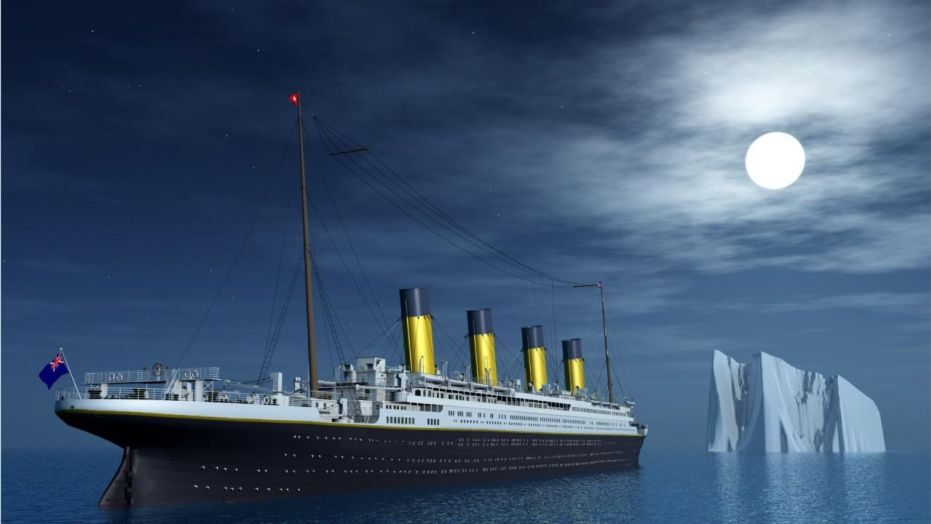

# Getting and Cleaning Data
This is a project defined on Kaggle Competition where you can find data of this project via this [link](https://www.kaggle.com/c/titanic/data). 

## Import Libraries 

In [84]:
import numpy as np  #linear algebra
import pandas as pd  #data processing
import matplotlib.pyplot as plt #visualization
import seaborn as sns
%matplotlib inline
import os #directory managment 
import requests
import json

In [85]:
import os 
os.chdir('/Users/Mehdi/Desktop/Desktop/Data Science/Courses/11.Data Science BootCamp/Py-DS-ML-Bootcamp-master/Refactored_Py_DS_ML_Bootcamp-master/13-Logistic-Regression')

## Read Files

In [86]:
train=pd.read_csv('titanic_train.csv')
X_test=pd.read_csv('titanic_test.csv')
y_test=pd.read_csv('gender_submission.csv')

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Check the Data types and find null values

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


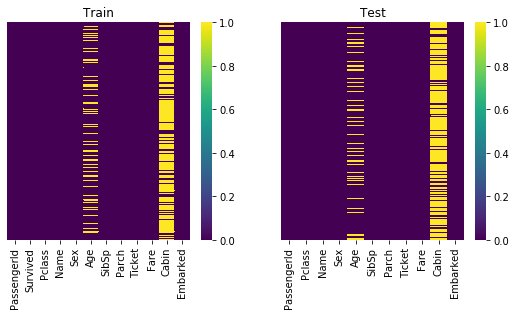

In [6]:
fig, axes=plt.subplots(1,2, figsize=(9,4))
plt.subplot(1,2,1)
sns.heatmap(train.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Train')
plt.subplot(1,2,2)
plt.title('Test')
sns.heatmap(X_test.isnull(), yticklabels=False, cmap='viridis')

## Find Percentage of Missing Data

In [87]:
itr=0
for dataset in [train, X_test]:
  itr=itr+1
  all_missing = dataset.isnull().sum().sort_values(ascending=False)
  percent = round(all_missing/dataset.count().max()*100, 2)
  name=pd.concat([all_missing, percent], axis=1, keys=['Total', '%'])
  if itr==1: 
    missing_train=name
    missing_train.columns = pd.MultiIndex.from_product([missing_train.columns, ['Train']])
    missing_train=missing_train.swaplevel(axis=1)
  else: 
    missing_test=name
    missing_test.columns = pd.MultiIndex.from_product([missing_test.columns, ['Test']])
    missing_test=missing_test.swaplevel(axis=1)
pd.concat([missing_test,missing_train], axis=1, sort=False)

Test        Train       
             Total      % Total      %
Cabin        327.0  78.23   687  77.10
Age           86.0  20.57   177  19.87
Fare           1.0   0.24     0   0.00
Embarked       0.0   0.00     2   0.22
Ticket         0.0   0.00     0   0.00
Parch          0.0   0.00     0   0.00
SibSp          0.0   0.00     0   0.00
Sex            0.0   0.00     0   0.00
Name           0.0   0.00     0   0.00
Pclass         0.0   0.00     0   0.00
PassengerId    0.0   0.00     0   0.00
Survived       NaN    NaN     0   0.00

**Cabin data has the most missing data in both test and train, makes it improper for any further analysis.**

# EDA & Feature Selection
## Gender, Pclass, Embark and Age

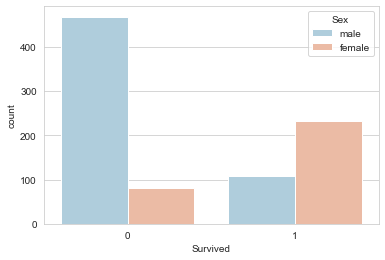

In [17]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex', data=train, palette='RdBu_r')

**Gender has a great impact on the survival rate as much more females survived than men did**

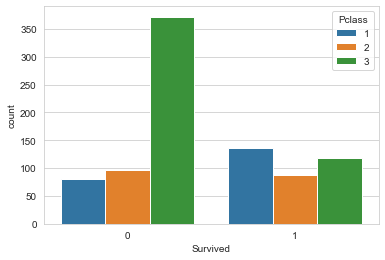

In [18]:
sns.countplot(x='Survived',hue='Pclass', data=train)

**Passenger Class also shows an impact as the ratio of survived over the total people increaes when move from cheap class to more luxerious class. Lets combine the above two parameters in one illustration to see combined effect**

Text(0.5, 1.0, 'Train')

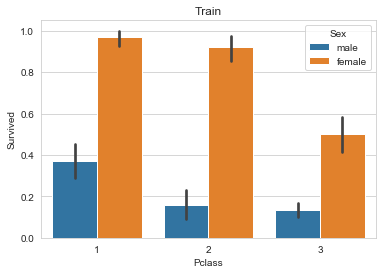

In [61]:
sns.barplot(y='Survived', x='Pclass',hue='Sex', data=train)
plt.title('Train')

**Survival rate is higher for females in all Pclasses, overal survival rate of female in the highest in class 2 among all clsses. Both Pclass and Sex will be selected features for tune our model.** 

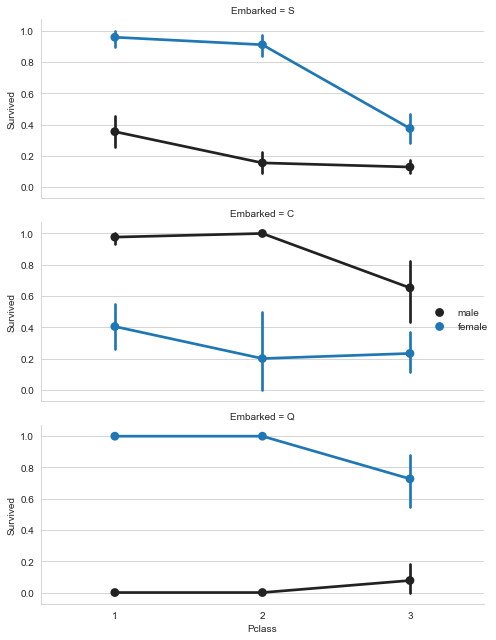

In [29]:
g=sns.FacetGrid(train, row='Embarked', aspect=2, height=3)
g.map(sns.pointplot, 'Pclass','Survived','Sex',order=None, hue_order=None)
g.add_legend()
plt.tight_layout()

**There is an obvious correlation between embark port and survival based on gender. It shows a good separation in survival rate between male and female per embark location. 
Women on port C and on port Q have a higher chance of survival whereas this trend is opposite for port C. 
Again, there is descending trend in survival when move from high class to low class tickets. Embark ports seems to be another good feature to select.**

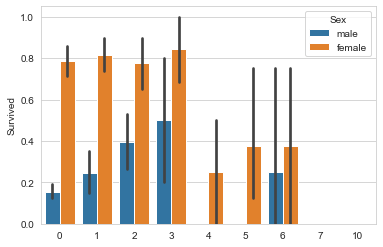

In [83]:
sns.barplot(x=train['SibSp']+train['Parch'],y='Survived' ,data=train, hue='Sex')

**Above plot: Chance of survival specially for men increases as the number of family members (siblings + parent/child) increases upto the number of 3, after which the overal chance of survival declines with almost no chance for men in a family size of 4 and 5. This separation of variation, makes both Siblings and ParentChild good features to use.**

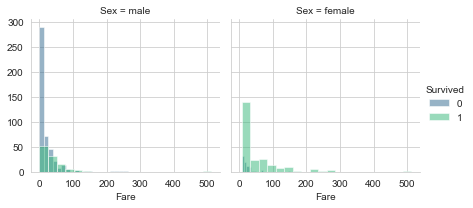

In [99]:
g=sns.FacetGrid(data=train, col='Sex', hue='Survived', palette='viridis')
g.map(plt.hist, 'Fare', alpha=.5, bins=20)
g.add_legend()

**It seems low fare ticket is associated with more risk specially for men. We will take this feature as well.**

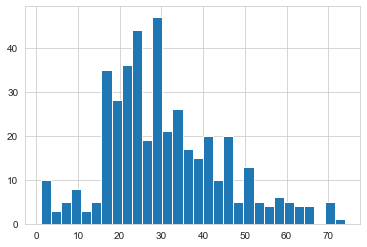

In [100]:
train[train['Survived']==0]['Age'].dropna().hist(bins=30)

**Above histogram shows a big cluster of victims aged between 18 to 30, majority of them belong to Pclass 3. Age a parameter which needs more attention.** 

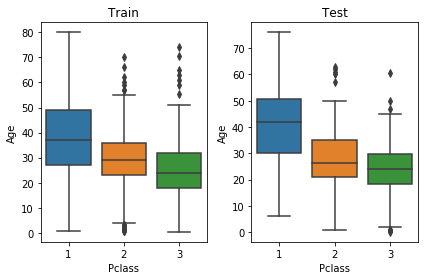

In [8]:
fig, axes=plt.subplots(1,2)
plt.subplot(1,2,1)
axes[0]=sns.boxplot(x='Pclass', y='Age', data=train)
plt.title('Train')
plt.subplot(1,2,2)
plt.title('Test')
sns.boxplot(x='Pclass', y='Age', data=X_test)
plt.tight_layout()

**There is a correlation between Ticket Class and age of passengers. Seems lots of bachelor young passengers purchased class 3 tickets. There is a good separation of age range based on ticket class. it makes Age another feature to take into account. However, null values must be replaced with some statistical measure such as mean, mode or median. Since Age and Class are correlated, we find the mean of age in each class for a better accuracy.**

In [9]:
X_test.groupby('Pclass').mean()

,PassengerId,Age,SibSp,Parch,Fare
Pclass,,,,,
1,1098.224299,40.918367,0.476636,0.383178,94.280297
2,1117.935484,28.777500,0.376344,0.344086,22.202104
3,1094.178899,24.027945,0.463303,0.417431,12.459678


In [65]:
train.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


## Replace null values in Age with it's mean per Pclass

In [88]:
data = [train, X_test]

for dataset in data:
    for i in range(3):
        ave = dataset.groupby('Pclass').mean().iloc[i]['Age']
        dataset.loc[(dataset['Age'].isnull()) & (dataset['Pclass']==i+1), 'Age']=round(ave,3)

**Embarked has 2 null values only, we can either drop those or replace it with most common data**

In [89]:
most=train['Embarked']. value_counts().index[0]

In [90]:
most

'S'

In [91]:
train['Embarked'].fillna(most, inplace=True)
X_test['Embarked'].fillna(most, inplace=True)

In [92]:
train['Embarked'].isnull().sum()

0

## Create More Feature
### Extract Titles and Convert it to a Numeric Variable
Title is a string type where should be converted to numerical data in order to use it for linear/Logestic regression.

In [93]:
titles=train['Name'].apply(lambda x:x.split('.')[0].strip().split(' ')[-1])
titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Don           1
Countess      1
Mme           1
Capt          1
Ms            1
Sir           1
Lady          1
Jonkheer      1
Name: Name, dtype: int64

**Some titles are actually the same (such as Miss, and Ms), and some titles are very low frequent that can be merged together to reduce the variability (such as Capt, Don, Jonkheer).** 

In [94]:
for dataset in [train, X_test]:
    titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Others": 5, "Dr":6, "Rev":7}
    dataset['Title']=dataset['Name'].str.extract(', ([a-zA-Z]+)\.', expand=False)
    dataset['Title']=dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title']=dataset['Title'].replace('Ms', 'Miss')
    dataset['Title']=dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title']=dataset['Title'].replace(['Col','Major','Jonkheer','Lady','Sir','Capt','Dona','Don'], 'Others')
    dataset['Title']=dataset['Title'].map(titles)
train.loc[train['Title'].isnull(), 'Name'] ## there is only a title contous with Nan title
train.loc[train['Title'].isnull(), 'Title']=5

In [95]:
print(X_test['Title'].isnull().sum(),
      train['Title'].isnull().sum())

0 0


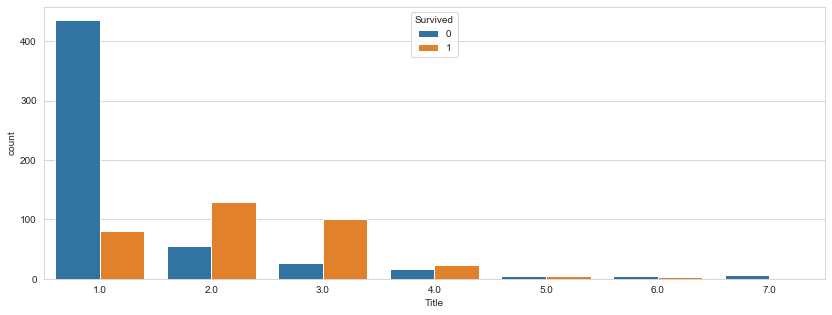

In [76]:
plt.figure(figsize=(14,5))
sns.countplot(x='Title', hue='Survived',data=train)

**Now, title is another feature for us to consider.**

# Data preparation

## Converting Embarked and Pclass to Numeric

In [96]:
ports = {"S": 0, "C": 1, "Q": 2}

for dataset in [train, X_test]:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [97]:
itr=0
for dataset in [train, X_test]:
    pclass=pd.get_dummies(dataset['Pclass'], drop_first=True)
    sex=pd.get_dummies(dataset['Sex'], drop_first=True)
    if itr==0:
        train=pd.concat([dataset, pclass, sex],axis=1);
        itr=itr+1;
    else: X_test=pd.concat([dataset, pclass, sex],axis=1)

In [180]:
train.info(),X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null int64
Title          891 non-null float64
2              891 non-null uint8
3              891 non-null uint8
male           891 non-null uint8
dtypes: float64(3), int64(6), object(4), uint8(3)
memory usage: 93.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-nu

(None, None)

## Drop Unnecessary Columns

In [98]:
for dataset in [train, X_test]:
    dataset.drop(['PassengerId','Sex','Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [99]:
X_train=train.drop('Survived', axis=1)
y_train=train['Survived']

In [100]:
X_test.fillna(0, inplace=True)

In [101]:
y_test.drop('PassengerId', axis=1, inplace=True)

# Model SetUp
## Linear Regression

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

In [103]:
lm=LinearRegression()

In [104]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [105]:
lmpredict=lm.predict(X_test)

### Converting Linear Regression to the Equivalent Logestic Regression

In [106]:
lmpredict[lmpredict>=0.5]=1
lmpredict[lmpredict<0.5]=0

In [107]:
print(classification_report(y_test, lmpredict))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       266
           1       0.93      0.97      0.95       152

    accuracy                           0.96       418
   macro avg       0.96      0.96      0.96       418
weighted avg       0.96      0.96      0.96       418



## Logestic Regression

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [112]:
model=LogisticRegression()

In [113]:
model.fit(X_train, y_train)

C:\Users\Mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
logpredict=model.predict(X_test)

In [115]:
print(classification_report(y_test,logpredict))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       266
           1       0.91      0.94      0.93       152

    accuracy                           0.94       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.95      0.94      0.95       418



## K Nearest Neighbour (KNN)

In [235]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [224]:
model=StandardScaler()

**We combine the X_train and X_test before standardizing the data**

In [201]:
X_test.shape , X_train.shape

((418, 10), (891, 10))

In [203]:
X_test.tail(3)

,Pclass,Age,SibSp,Parch,Fare,Embarked,Title,2,3,male
415,3,38.500,0,0,7.2500,0,1,0,1,1
416,3,24.028,0,0,8.0500,0,1,0,1,1
417,3,24.028,1,1,22.3583,1,4,0,1,1


In [204]:
X_train.tail(3)

,Pclass,Age,SibSp,Parch,Fare,Embarked,Title,2,3,male
888,3,25.141,1,2,23.45,0,2.0,0,1,0
889,1,26.000,0,0,30.00,1,1.0,0,0,1
890,3,32.000,0,0,7.75,2,1.0,0,1,1


In [206]:
traincombined=pd.concat([X_train, X_test])

In [226]:
## to fit the data into object, to Compute the mean and std to be used for later scaling.
## and to transform (standardize) the scaler object
scaled_feat=model.fit_transform(traincombined)

In [227]:
df_feat=pd.DataFrame(scaled_feat, columns=traincombined.columns)

In [228]:
df_feat.head(3) # Standardized DataFrame of all data rows

,Pclass,Age,SibSp,Parch,Fare,Embarked,Title,2,3,male
0,0.841916,-0.558556,0.481288,-0.445,-0.503023,-0.603436,-0.687275,-0.518084,0.919925,0.743497
1,-1.546098,0.660705,0.481288,-0.445,0.734878,0.927373,1.143127,-0.518084,-1.087045,-1.344995
2,0.841916,-0.253741,-0.479087,-0.445,-0.489974,-0.603436,0.227926,-0.518084,0.919925,-1.344995


In [229]:
df_feat.shape

(1309, 10)

**Split again into X_train and X_test based on original dimentions**

In [231]:
X_train_stand=df_feat.iloc[:891]
X_test_stand=df_feat.iloc[891:]

### Create the Error vector for different k values

In [236]:
error_rate=[]

for i in range(1,40):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_stand, y_train)
    pred=knn.predict(X_test_stand)
    error_rate.append(confusion_matrix(y_test, pred)[0,1]+confusion_matrix(y_test, pred)[1,0])
    ## error_rate.append(sum(pred!=y_test)) does the same thing
error_rate=pd.DataFrame(error_rate, index=range(1,40), columns=['error'])

**Plot the Error Vector to identify the optimum k**

Text(0, 0.5, 'Error')

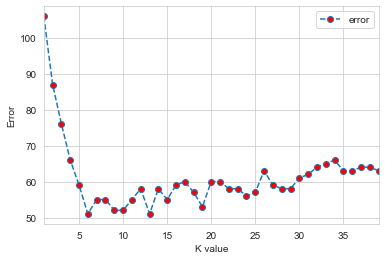

In [237]:
error_rate.plot(marker='o', linestyle='--', markerfacecolor='red')
plt.xlabel('K value')
plt.ylabel('Error')

**k = 6 looks to be optimum with minimum error**

In [239]:
knn=KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
pred=knn.predict(X_test)

print(classification_report(y_test,pred))
print('\n')
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       266
           1       0.62      0.51      0.56       152

    accuracy                           0.71       418
   macro avg       0.68      0.66      0.67       418
weighted avg       0.70      0.71      0.70       418



[[218  48]
 [ 75  77]]


## To be continued